## 회귀 (dnn : 전결함층)
- 하나의 수치 예측 모델 제작
- x : 광고비용
- y : 매출액

In [16]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/click' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 10          # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 인치 단위 크기, width, height
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [17]:
data = np.loadtxt('./click.csv', delimiter=',', skiprows=1, dtype=np.float64)
print(type(data))
print(data.shape)
print(data[:5])

<class 'numpy.ndarray'>
(20, 2)
[[235. 591.]
 [216. 539.]
 [148. 413.]
 [ 35. 310.]
 [ 85. 308.]]


In [18]:
# y = as + b
# 독립변수 x
x_train = data[:, 0]
print(x_train)

[235. 216. 148.  35.  85. 204.  49.  25. 173. 191. 134.  99. 117. 112.
 162. 272. 159. 159.  59. 198.]


In [19]:
# 종속변수 y
y_train = data[:, 1]
print(y_train)

[591. 539. 413. 310. 308. 519. 325. 332. 498. 498. 392. 334. 385. 387.
 425. 659. 400. 427. 319. 522.]


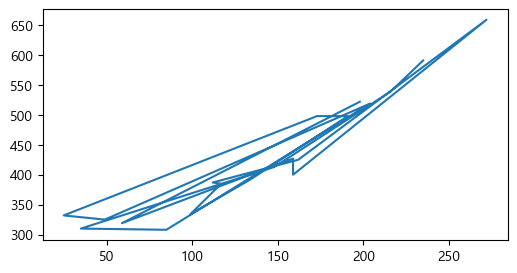

In [20]:
plt.plot(x_train, y_train)
plt.show()

In [21]:
print(x_train)
idx = data[:, 0].argsort() # 값을 정렬한 후 해당 값의 index 추출, 원본 변경 안됨
print(f'idx: {idx}')       # 25, 35, 49 
print(data[idx])           # 이미 정렬된 index값에 따라 값이 출력됨.

[235. 216. 148.  35.  85. 204.  49.  25. 173. 191. 134.  99. 117. 112.
 162. 272. 159. 159.  59. 198.]
idx: [ 7  3  6 18  4 11 13 12 10  2 17 16 14  8  9 19  5  1  0 15]
[[ 25. 332.]
 [ 35. 310.]
 [ 49. 325.]
 [ 59. 319.]
 [ 85. 308.]
 [ 99. 334.]
 [112. 387.]
 [117. 385.]
 [134. 392.]
 [148. 413.]
 [159. 427.]
 [159. 400.]
 [162. 425.]
 [173. 498.]
 [191. 498.]
 [198. 522.]
 [204. 519.]
 [216. 539.]
 [235. 591.]
 [272. 659.]]


In [22]:
print(data[idx][:: -1])   

[[272. 659.]
 [235. 591.]
 [216. 539.]
 [204. 519.]
 [198. 522.]
 [191. 498.]
 [173. 498.]
 [162. 425.]
 [159. 400.]
 [159. 427.]
 [148. 413.]
 [134. 392.]
 [117. 385.]
 [112. 387.]
 [ 99. 334.]
 [ 85. 308.]
 [ 59. 319.]
 [ 49. 325.]
 [ 35. 310.]
 [ 25. 332.]]


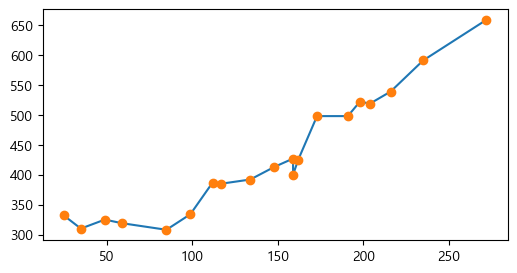

In [23]:
ds = data[idx]
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)
plt.plot(x_train, y_train, 'o')
plt.show()

# node(뉴런) 1개 사용하는 경우 

In [24]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# 1 : 뉴런의 수 
# input_dim : 입력 데이처의 수(x의 수)
# activation : 활성화 함수

# 1 : 출력 노드 수, input_dim : 입력 노드 수, activation : 활성화 함수
# linear : 활성화함수 선택, linear는 디폴트 값으로 입력된 값 그대로 출력, 생략가능
# linear : 활성화 함수, 회귀 연산을 변형하지 않고 출력.
# name : 레이어 이름, 생략가능
model.add(Dense(1, input_dim=1, activation='linear', name = 'layer1'))
# optimizer : 실제 값과 비교해 오차를 산출 후 
#   오차가 감소되는 방향으로 가중치화 편향을 감고 시키는 최적화 함수, 
#   adam은 딥러닝에서 가장 많이 사용되는 최적화 함수
# loss : 손실 함수 
#   mse : 평균 제곱 오차, 회귀 문제에서 자주 사용되는 손실 함수
#         찾아야할 목표값과의 차이를 제곱하여 합을 구한 후 평균한 값
model.compile(optimizer='adam', loss='mse')
model.summary()

#history = model.fit(x_train, y_train, epochs=1000, verbose=0)
# x_train : 입력 데이터, 훈련 데이터, 됵립변수
# y_train : 출력 데이터, 훈련 데이터, 종속변수
# validation_split : 검증 데이터의 비율, 0.2는 20%를 검증 데이터로 사용
# shuffle : 훈련 데이터를 무작위로 섞음
# epochs : 훈련 횟수
# batch_size : 배치 크기, 1은 전체 데이터를 1개씩 미니 배치로 사용
#            1건씩 읽어서 오차를 수한 후 가중치(기울기)와 편향(y절편)을 갱신
# 16/16 (전체 데이터 - 검증데이터20%) / batch_size(1)
# (20-4) / 1 = 16
# 전체 최적화 횟수 : epochs * 최적화 횟수
# 10*16 = 160
# 검증시에는 가중치화 편향을 변경하지 않음.
history = model.fit(x_train, y_train, 
                    validation_split=0.2, shuffle=True, 
                    epochs=10, batch_size=1, )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


16/16 [==============================] - 0s 7ms/step - loss: 238497.2969 - val_loss: 553888.2500
Epoch 2/10
16/16 [==============================] - 0s 2ms/step - loss: 236730.8906 - val_loss: 549269.5625
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 235076.7656 - val_loss: 544442.3750
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 233431.1250 - val_loss: 539638.1250
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 231646.6562 - val_loss: 535222.4375
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 230005.5156 - val_loss: 530647.8125
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 228405.3906 - val_loss: 525816.7500
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 226636.1562 - val_loss: 521461.2500
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 225057.8594 - val_loss: 516790.3438
Epoch 10/10
16/16 [====================

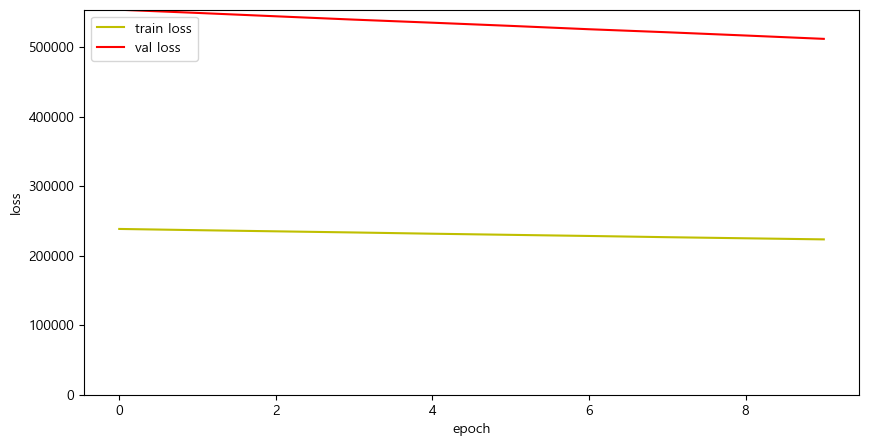

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 553888]) # 값을 반영하여 변경 ★

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()
# train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.

In [26]:
# 데이터 : 훈련, 검증, 테스트로 분할을 거침
# train loss, val loss가 하강한다는 것은 X를가지고 Y를 예측하는데 있어서
# 점점 오차가 줄어든다는 것임

# 테스트 데이터 준비, 훈련/검증에 사용하지 않은 데이터
x = np.array([50, 120, 140, 160, 250]) # 1차원 배열
print(x.shape) # (5,)
print('-' * 30)

p = model.predict(x) # 모델 사용, 2차원 배열
print(type(p))
print(p.shape) # (5, 1): 데이터 입력 건수가 5건이고 출력 데이터 갯수가 1개임
print(p)

(5,)
------------------------------
<class 'numpy.ndarray'>
(5, 1)
[[ -29.040886]
 [ -69.915985]
 [ -81.59458 ]
 [ -93.273186]
 [-145.82689 ]]


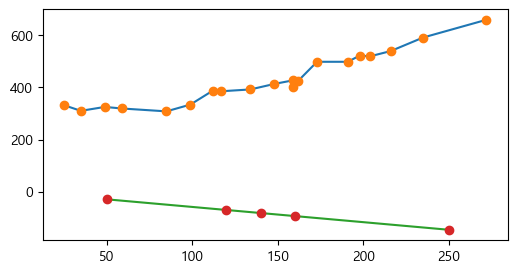

In [31]:
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)      # 기본 데이터 선 그래프
plt.plot(x_train, y_train, 'o') # 기본 데이터 마커
plt.plot(x, p)        # [50, 120, 140, 160, 250] 예측 선그래프
plt.plot(x, p, 'o')   # [50, 120, 140, 160, 250] 예측 마커
plt.show()

### 뉴런(노드)의 수를 늘린다.

In [ ]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# 1 : 뉴런의 수 
# input_dim : 입력 데이처의 수(x의 수)
# activation : 활성화 함수

# 1 : 출력 노드 수, input_dim : 입력 노드 수, activation : 활성화 함수
# linear : 활성화함수 선택, linear는 디폴트 값으로 입력된 값 그대로 출력, 생략가능
# linear : 활성화 함수, 회귀 연산을 변형하지 않고 출력.
# name : 레이어 이름, 생략가능
# 여기 dense 의 첫번쨰 parameter(뉴런 수)을 바꿔가면서 결과를 볼것.
# 뉴런 조정이 사용자 역량이 필요한 부분.
    # 1. 뉴런 수를 늘리면, 오차가 줄어들지만, 과적합이 발생할 수 있음.
    # 2. 뉴런 수를 줄이면, 오차가 커지지만, 과적합이 줄어듬.
    # 3. 뉴런 수를 적절히 조절해야함.
    # 모델러가 데이터를 잘 이해하고 있어야함.
    # 데이터를 잘 이해하고 있으면, 뉴런 수를 적절히 조절할 수 있음.
model.add(Dense(100, input_dim=1, activation='linear', name = 'layer1'))
model.add(Dense(1, activation='linear', name = 'layer2'))

# optimizer : 실제 값과 비교해 오차를 산출 후 
#   오차가 감소되는 방향으로 가중치화 편향을 감고 시키는 최적화 함수, 
#   adam은 딥러닝에서 가장 많이 사용되는 최적화 함수
# loss : 손실 함수 
#   mse : 평균 제곱 오차, 회귀 문제에서 자주 사용되는 손실 함수
#         찾아야할 목표값과의 차이를 제곱하여 합을 구한 후 평균한 값
model.compile(optimizer='adam', loss='mse')
model.summary()

#history = model.fit(x_train, y_train, epochs=1000, verbose=0)
# x_train : 입력 데이터, 훈련 데이터, 됵립변수
# y_train : 출력 데이터, 훈련 데이터, 종속변수
# validation_split : 검증 데이터의 비율, 0.2는 20%를 검증 데이터로 사용
# shuffle : 훈련 데이터를 무작위로 섞음
# epochs : 훈련 횟수
# batch_size : 배치 크기, 1은 전체 데이터를 1개씩 미니 배치로 사용
#            1건씩 읽어서 오차를 수한 후 가중치(기울기)와 편향(y절편)을 갱신
# 16/16 (전체 데이터 - 검증데이터20%) / batch_size(1)
# (20-4) / 1 = 16
# 전체 최적화 횟수 : epochs * 최적화 횟수
# 10*16 = 160
# 검증시에는 가중치화 편향을 변경하지 않음.
history = model.fit(x_train, y_train, 
                    validation_split=0.2, shuffle=True, 
                    epochs=10, batch_size=1, )

In [41]:
# 데이터 : 훈련, 검증, 테스트로 분할을 거침
# train loss, val loss가 하강한다는 것은 X를가지고 Y를 예측하는데 있어서
# 점점 오차가 줄어든다는 것임

# 테스트 데이터 준비, 훈련/검증에 사용하지 않은 데이터
x = np.array([50, 120, 140, 160, 250]) # 1차원 배열
print(x.shape) # (5,)
print('-' * 30)

p = model.predict(x) # 모델 사용, 2차원 배열
print(type(p))
print(p.shape) # (5, 1): 데이터 입력 건수가 5건이고 출력 데이터 갯수가 1개임
print(p)

(5,)
------------------------------
<class 'numpy.ndarray'>
(5, 1)
[[131.7708 ]
 [313.1836 ]
 [365.01584]
 [416.84805]
 [650.0931 ]]


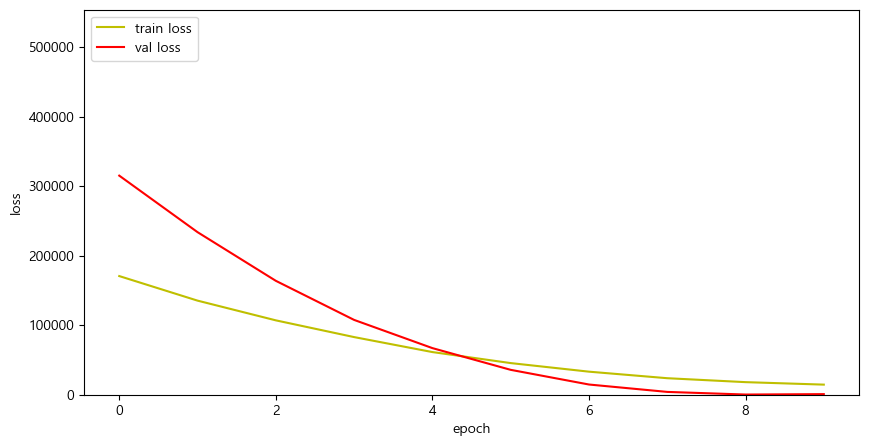

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 553888]) # 값을 반영하여 변경 ★

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()
# train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.

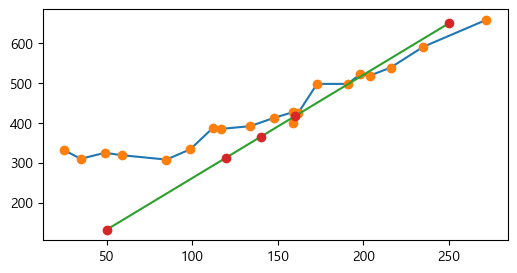

In [43]:
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)      # 기본 데이터 선 그래프
plt.plot(x_train, y_train, 'o') # 기본 데이터 마커
plt.plot(x, p)        # [50, 120, 140, 160, 250] 예측 선그래프
plt.plot(x, p, 'o')   # [50, 120, 140, 160, 250] 예측 마커
plt.show()

# mpdel 저장 및 로드

In [44]:
model.save('click.h5') # 모델 저장

In [48]:
model = load_model('click.h5') # 모델 사용

In [46]:
x = np.array([50, 120, 140, 160, 250]) # 1차원 배열... 없는 데이터로만
# print(x.shape) # (5,)
print(x)

[ 50 120 140 160 250]


In [47]:
p = model.predict(x) # 모델 사용, 2차원 배열
print(p.shape) # (5, 1): 데이터 입력 건수가 5건이고 출력 데이터 갯수가 1개임
print(p)

(5, 1)
[[131.7708 ]
 [313.1836 ]
 [365.01584]
 [416.84805]
 [650.0931 ]]
